# Установка зависимостей

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader

# Реализация архитектуры U-Net

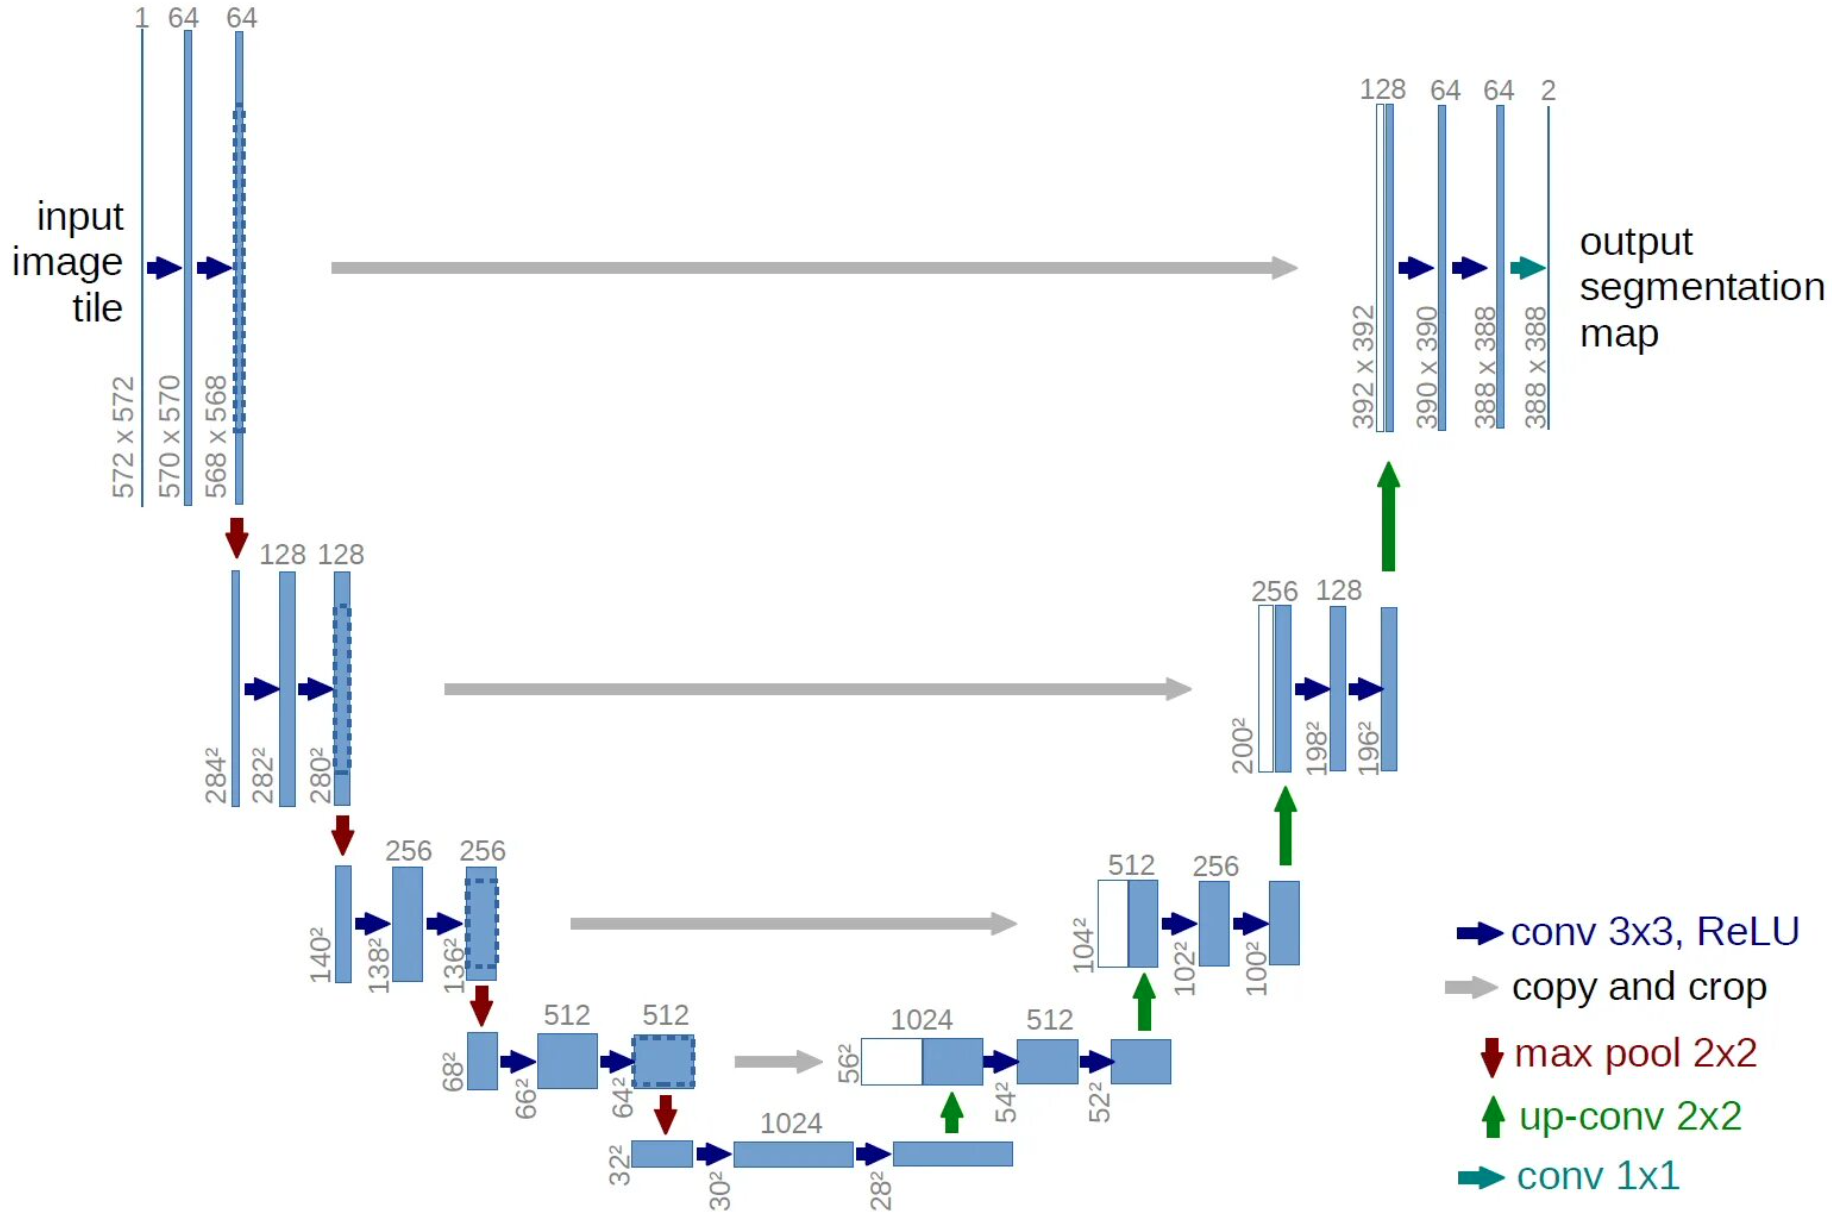

In [2]:
def scale_tensor(image ,new_height , new_width):
    '''! Функция изменения размера тензора, где
    :param image: изображение,
    :param new_height: новая высота,
    :param new_width: новая ширина,
    :return scaled_image: изображение с новой высотой и шириной'''
    scaled_image = F.interpolate(image, size=(new_height, new_width), mode='bilinear', align_corners=True)
    return scaled_image

In [ ]:
def double_conv(in_ch, out_ch):
    '''! Функция, дважды применяющая свертку 3x3, где
    :param in_ch: кол-во входных признаков,
    :param out_ch: кол-во выходных признаков,
    :return conv: результат свертки'''
    conv = nn.Sequential(
        nn.BatchNorm2d(in_ch),
        nn.Conv2d(in_ch, out_ch, kernel_size=3),
        nn.BatchNorm2d(out_ch),
        nn.Relu(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3),
        nn.BatchNorm2d(out_ch),
        nn.Relu(inplace=True)
    )

In [ ]:
def crop_image(target_img, img):
    '''! Функция обрезания изображения (тензора), где
    :param target_img: желаемое изображение (тензор),
    :param img: текущее изображение (тензор),
    :return tensor: искомый тензор'''
    target_size = target_img.size()[2]
    tensor_size = img.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:, :, delta:tensor_size- delta, delta:tensor_size-delta]

In [ ]:
def output_layer(in_ch, out_ch):
    '''! Функция, отвечающая за выходной слой, где
    :param in_ch: кол-во входных признаков,
    :param out_ch: кол-во выходных признаков,
    :return conv_layer: выходной слой'''
    conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=1),
        nn.BatchNorm2d(out_ch),
        #nn.Sigmoid()
    )
    return conv_layer

In [ ]:
def pad_image_to_square(img, num):
    '''! Функция добавление пустых пикселей по краям,
    чтобы сделать изображение квадратным, где
    :param img: изображение,
    :param num: желаемая длина одной стороны фотографии,
    :return padded_img: дополненное до нужного размера изображение'''

    channels, height, width = img.size()
    diff = abs(num - width)
    # Определение кол-ва пикселей для добавления
    padding = diff // 2

    # дополнение до желаемого размера
    img = torch.nn.functional.pad(img, (padding, diff - padding, 0, 0), mode='constant', value=0)
    print(img.shape)

    channels, height, width = img.size()
    diff = abs(height-width)
    #Определение кол-ва пикселей для добавления
    padding = diff // 2


    # Дополнение тензора
    if height < width:
        padded_img = torch.nn.functional.pad(img, (0, 0, padding, diff - padding), mode='constant', value=0)
    else:
        padded_img = torch.nn.functional.pad(img, (padding, diff - padding, 0, 0), mode='constant', value=0)


    return padded_img

In [ ]:
class Unet(nn.Module):
    '''! Реализация архитектуры U-Net'''

    def __init__(self):
        super(Unet, self).__init__()

        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        #Левая часть
        self.down_conv1 = double_conv(1, 64)
        self.down_conv2 = double_conv(64, 128)
        self.down_conv3 = double_conv(128, 256)
        self.down_conv4 = double_conv(256, 512)
        self.down_conv5 = double_conv(512, 1024)
        #trans - transpose
        #Правая часть
        self.conv_bn=nn.BatchNorm2d(1024)
        self.up_trans1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2, stride=2
            )
        self.up_conv1 = double_conv(1024, 512)
        self.up_trans2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2, stride=2
            )
        self.up_conv2 = double_conv(512, 256)
        self.up_trans3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2, stride=2
            )
        self.up_conv3 = double_conv(256, 128)
        self.up_trans4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2, stride=2
            )
        self.up_conv4 = double_conv(128, 64)

        #выходной слой
        self.out = output_layer(64, 1)

    def forward(self, image):
        # Forward pass для левой части
        down1 = self.down_conv1(image)
        down2 = self.maxpool2d(down1)
        down3 = self.down_conv2(down2)
        down4 = self.maxpool2d(down3)
        down5 = self.down_conv3(down4)
        down6 = self.maxpool2d(down5)
        down7 = self.down_conv4(down6)
        down8 = self.maxpool2d(down7)
        down9 = self.down_conv5(down8)

        # Forward pass для правой части
        x_norm = self.conv_bn(down9)
        x = self.up_trans1(x_norm)
        y = crop_tensor(x, down7)
        x = self.up_conv1(torch.cat([x,y], 1))

        x = self.up_trans2(x)
        y = crop_tensor(x, down5)
        x = self.up_conv2(torch.cat([x,y], 1))

        x = self.up_trans3(x)
        y = crop_tensor(x, down3)
        x = self.up_conv3(torch.cat([x,y], 1))

        x = self.up_trans4(x)
        y = crop_tensor(x, down1)
        x = self.up_conv4(torch.cat([x,y], 1))

        return self.out(x)

# Обучение

### Определение гиперпараметров и устройства для обучения

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#batch_size = 4
learning_rate = 0.001
num_epochs = 10

### Определение архитектуры, loss-функции и оптимизатора

In [ ]:
# определение используемой архитектуры
model = Unet()
if torch.cuda.is_available():
    model.cuda()

# функция потерь и оптимизатор
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

valid_loss , train_loss = [] , []

### Запуск обучения модели

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        # Прямое распространение ошибки
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # Обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        model.eval()
        val_loss = 0
        for inputs, targets in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets)
        val_loss /= len(val_dataloader)
    valid_loss.append(val_loss.item())
    train_loss.append(loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}  , Val Loss: {val_loss.item():.4f}")


### Визуализация результатов обучения

In [ ]:
import matplotlib.pyplot as plt
plt.plot(v_loss)
plt.plot(train_loss)
plt.legend(["Validation loss" , "Training loss"])
plt.xlabel("epochs")
plt.ylabel("loss")

# Тестирование

### Предсказание для тестовых данных

In [ ]:
import itertools
batches = list(itertools.islice(test, 2))

out = []
test = []
test1 = []

with torch.no_grad():
  for batch in batches:
      inputs = batch[0].to(device)
      test.append(inputs)
      test1.append(batch[1].to(device))
      outputs = model(inputs)
      out.append(outputs)
      torch.cuda.empty_cache()
      gc.collect()
      print(batch[0].shape)

### Просмотр результатов

In [ ]:
import matplotlib.pyplot as plt
import torch

tensor = out[0].cpu().detach().numpy()

# Вывод нескольких изображений одновременно
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(tensor[i, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [ ]:
tensor_train = test[0].cpu().detach().numpy()

# Вывод нескольких изображений одновременно
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(tensor_train[i, 0], cmap='gray')
    axs[i].axis('off')
plt.show()